# **(d) Análisis de robustez de los grafos.**

d.1 Hacer un análisis de robustez, en el cual se borran los enlaces de un nodo a la vez, hasta borrar todos los enlaces del grafo. 

d.2 Comparar el efecto de borrar seleccionando nodos al azar, con el efecto de ir borrando primero los enlaces de los nodos con mayor centralidad. Usar las medidas de centralidad que se calcularon en el punto anterior.

A medida que se van borrando los enlaces, para grafos no dirigidos cuantificar la robustez de los grafos por dos vías:

1. Calculando el tamaño relativo de la componente gigante resultante ($N_g/N$).
2. Calculando la *eficiencia global* del grafo.

Para grafos dirigidos usar solo $N_g/N$ (ya que la eficiencia global no está implementada para grafos dirigidos).

Un grafico comparando la componente gigante vs los 3 tipos de ataques elegidos
Un grafico comparando la eficiencia global vs los 3 tipos de ataques elegidos

In [29]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.approximation import average_clustering
import community.community_louvain as cl
import pickle
import random

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

from sklearn.metrics import adjusted_rand_score

# Funciones de utiles.py
from utiles import read_graph , read_graph_weighted,get_graph_pos , drop_weights

## 0. Carga de datos
Primero, leemos los dos datasets y las etiquetas del dataset de email.

Las etiquetas para email indican a que departamento pertenece cada nodo (por ej. el nodo 3 pertenece al departamento 21

In [30]:
EMAIL_PATH = 'datasets/email.txt'
TERRORIST_PATH = 'datasets/terrorist.txt'
EMAIL_LABELS_PATH = 'datasets/email_labels.txt'

# Leemos los grafos
email = read_graph(EMAIL_PATH)
terr= read_graph_weighted(TERRORIST_PATH)

# Leemos las etiquetas del dataset de email
array = np.loadtxt(EMAIL_LABELS_PATH, dtype=int)
email_labels=list(array[:,1]) 

Posteriormente, cargamos los datasets con la centralidad por grado e intermediación para ambos sets de datos (los utilizaremos para eliminar según la centralidad)

In [31]:
# Cargar centralidades desde CSVs

# Terrorist Unweighted
terrorist_intermediacion = pd.read_csv('datasets/centralidad/terrorist_unweighted_intermediacion.csv')
terrorist_grado = pd.read_csv('datasets/centralidad/terrorist_unweighted_grado.csv')

# Email Giant
email_intermediacion = pd.read_csv('datasets/centralidad/email_giant_intermediacion.csv')
email_grado = pd.read_csv('datasets/centralidad/email_giant_grado.csv')

Después, quitamos los pesos al grafo de terroristas para poderlo estudiar.

In [32]:
terrorist_unweighted = terr.copy()
drop_weights(terrorist_unweighted)
terrorist_unweighted.remove_edges_from(nx.selfloop_edges(terrorist_unweighted)) #remuevo autoenlaces NO HAY
print(terrorist_unweighted)

Graph with 64 nodes and 243 edges


Nos quedamos solo con el componente gigante de email, ya que no está completamente conectado.

In [33]:
email.remove_edges_from(nx.selfloop_edges(email))  # Borrar autoenlaces
emailcc = sorted(nx.connected_components(email), key=len, reverse=True)
email_giant = email.subgraph(emailcc[0])

## 1. Análisis de robustez
### 1.0. Definición funciones de eliminación de nodos

In [34]:
def random_node_delete(g):
    """
    Parámetros:
    - g: Grafo original (NetworkX Graph).

    Retorna:
    - deleted_node_list: nodos eliminados en orden.
    - ng_list: tamaño relativo de la componente gigante por paso.
    - eff_list: eficiencia global en cada iteración.
    """
    graph = g.copy()
    nodes = list(graph.nodes())
    random.shuffle(nodes)
    n_total = graph.number_of_nodes()

    deleted_node_list = []
    ng_list = []
    eff_list = []

    while nodes and graph.number_of_edges() > 0: 
        node = nodes.pop()
        graph.remove_node(node)

        if graph.number_of_nodes() > 1:
            giant_cc = max(nx.connected_components(graph), key=len)
            ng = len(giant_cc) / n_total
            eff = nx.global_efficiency(graph)
        else:
            ng = 0
            eff = 0
        
        deleted_node_list.append(node)
        ng_list.append(ng)
        eff_list.append(eff)

    return deleted_node_list, ng_list, eff_list

In [35]:
def node_list_delete(g, nl):
    """
    Parámetros:
    - g: Grafo original (NetworkX Graph).
    - nl: Lista ordenada de nodos a eliminar.

    Retorna:
    - nl: nodos eliminados en orden.
    - ng_list: tamaño relativo de la componente gigante por paso.
    - eff_list: eficiencia global en cada iteración.
    """
    graph = g.copy()
    node_list = nl.copy()
    n_total = graph.number_of_nodes()

    ng_list = []
    eff_list = []

    for node in node_list:
        graph.remove_node(node)

        if graph.number_of_nodes() > 1:
            giant_cc = max(nx.connected_components(graph), key=len)
            ng = len(giant_cc) / n_total
            eff = nx.global_efficiency(graph)
        else:
            ng = 0
            eff = 0
        
        ng_list.append(ng)
        eff_list.append(eff)
        
    return nl, ng_list, eff_list

In [46]:
def plot_robustness_comparison(csv_paths, labels, ylabel, output_path=None):

    colors = ['royalblue', 'darkorange', 'forestgreen']
    plt.figure(figsize=(10, 6))

    for path, label, color in zip(csv_paths, labels, colors):
        df = pd.read_csv(path)
        y_values = df[ylabel].values
        x_values = range(len(y_values))
        plt.plot(x_values, y_values, label=label, color=color, linewidth=2, marker='o', markersize=4)

    plt.xlabel('Nodos eliminados', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=12)
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300)
    plt.show()


### 1.1. Terroristas
#### 1.1.1. Eliminación aleatoria

In [37]:
# Eliminación aleatoria
terr_rand_deleted_nodes_list, terr_rand_ng_list, terr_rand_eff_list = random_node_delete(terrorist_unweighted)
print(f"Nodos eliminados: \n{terr_rand_deleted_nodes_list}")

Nodos eliminados: 
[np.int64(9), np.int64(44), np.int64(24), np.int64(25), np.int64(51), np.int64(20), np.int64(45), np.int64(47), np.int64(36), np.int64(50), np.int64(35), np.int64(61), np.int64(10), np.int64(12), np.int64(34), np.int64(19), np.int64(33), np.int64(11), np.int64(21), np.int64(31), np.int64(39), np.int64(14), np.int64(4), np.int64(52), np.int64(7), np.int64(29), np.int64(13), np.int64(53), np.int64(63), np.int64(0), np.int64(48), np.int64(43), np.int64(42), np.int64(49), np.int64(62), np.int64(56), np.int64(37), np.int64(38), np.int64(40), np.int64(1), np.int64(8), np.int64(28), np.int64(55), np.int64(15), np.int64(41), np.int64(32), np.int64(5), np.int64(18), np.int64(54), np.int64(17), np.int64(60), np.int64(3), np.int64(23), np.int64(59), np.int64(2), np.int64(30), np.int64(57), np.int64(26), np.int64(27), np.int64(16), np.int64(46), np.int64(58)]


#### 1.1.2. Eliminación según centralidad de grado

In [38]:
# Lista de nodos ordenados de forma descendiente por centralidad de grado
terrorist_grado_nodos = list(terrorist_grado["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de grado: \n{terrorist_grado_nodos}")

terr_grad_deleted_nodes_list, terr_grad_ng_list, terr_grad_eff_list = node_list_delete(terrorist_unweighted, terrorist_grado_nodos)

Nodos ordenados de mayor a menor centralidad de grado: 
[0, 2, 6, 9, 24, 15, 17, 16, 21, 29, 20, 22, 19, 13, 14, 23, 48, 3, 25, 28, 4, 12, 11, 10, 27, 18, 45, 5, 49, 35, 7, 30, 50, 51, 52, 40, 46, 58, 43, 39, 55, 54, 8, 26, 56, 44, 57, 1, 31, 33, 62, 63, 60, 36, 38, 32, 53, 42, 41, 37, 34, 59, 47, 61]


#### 1.1.3. Eliminación según centralidad de intermediación

In [39]:
# Lista de nodos ordenados de forma descendiente por centralidad de intermediación
terrorist_intermediacion_nodos = list(terrorist_intermediacion["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de intermediación: \n{terrorist_intermediacion_nodos}")

terr_betw_deleted_nodes_list, terr_betw_ng_list, terr_betw_eff_list = node_list_delete(terrorist_unweighted, terrorist_intermediacion_nodos)


Nodos ordenados de mayor a menor centralidad de intermediación: 
[48, 0, 2, 23, 6, 21, 17, 16, 29, 18, 9, 45, 24, 5, 15, 22, 14, 35, 44, 43, 20, 58, 30, 19, 13, 7, 51, 50, 49, 52, 25, 40, 39, 38, 31, 32, 28, 27, 8, 12, 1, 4, 26, 3, 11, 10, 36, 34, 55, 54, 53, 42, 41, 33, 37, 56, 63, 62, 59, 57, 46, 47, 60, 61]


#### 1.1.4. Opcional: Guardado de resultados en archivos .csv

In [40]:
# Crear folder si no existe
os.makedirs('datasets/robustez', exist_ok=True)

# 1. Eliminación aleatoria
df = pd.DataFrame({
    "nodo_eliminado": terr_rand_deleted_nodes_list,
    "Ng/N": terr_rand_ng_list,
    "eficiencia_global": terr_rand_eff_list
})
df.to_csv("datasets/robustez/terrorist_random_node_delete.csv", index=False)

# 2. Centralidad de grado
df = pd.DataFrame({
    "nodo_eliminado": terr_grad_deleted_nodes_list,
    "Ng/N": terr_grad_ng_list,
    "eficiencia_global": terr_grad_eff_list
})
df.to_csv("datasets/robustez/terrorist_grade_node_delete.csv", index=False)

# 3. Centralidad de intermediación
df = pd.DataFrame({
    "nodo_eliminado": terr_betw_deleted_nodes_list,
    "Ng/N": terr_betw_ng_list,
    "eficiencia_global": terr_betw_eff_list
})
df.to_csv("datasets/robustez/terrorist_betweenness_node_delete.csv", index=False)


#### 1.1.5. Gráfico

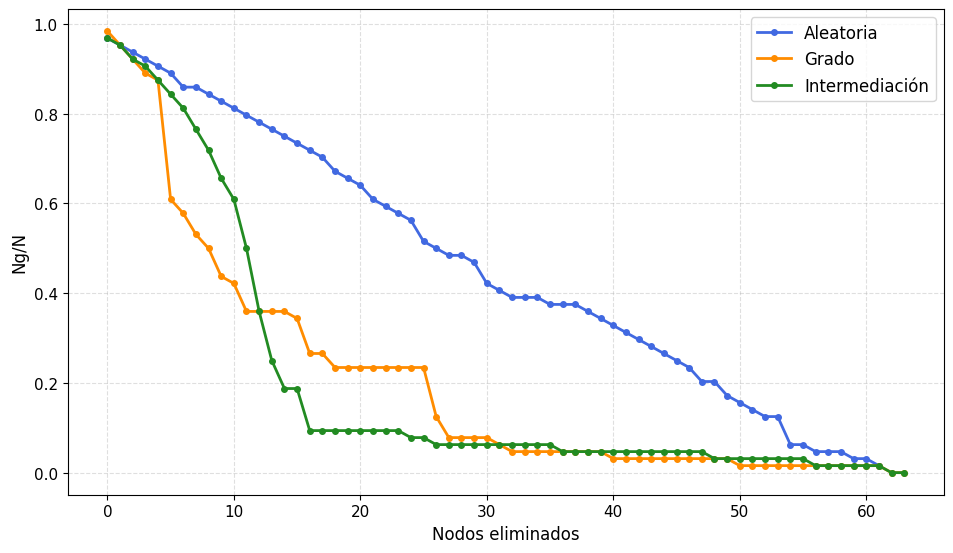

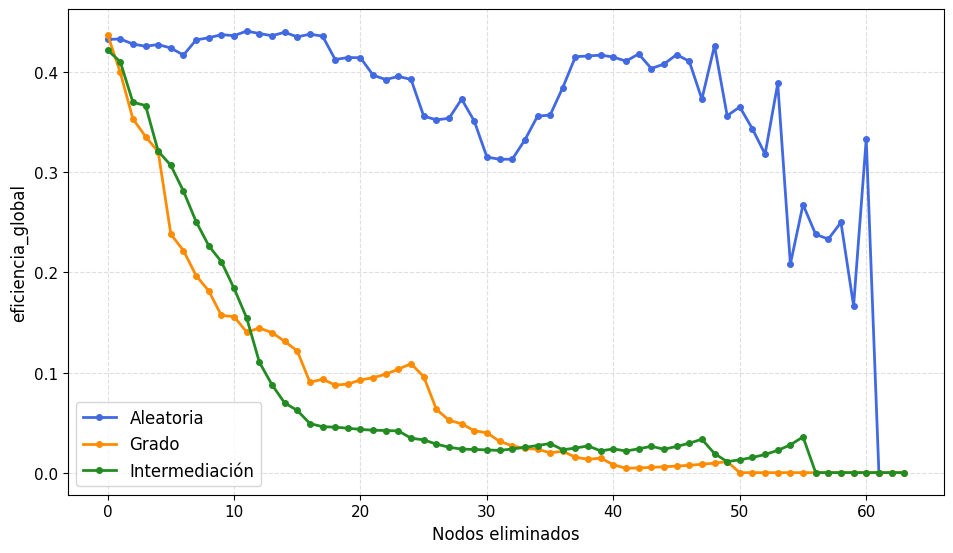

In [43]:
csvs = [
    'datasets/robustez/terrorist_random_node_delete.csv',
    'datasets/robustez/terrorist_grade_node_delete.csv',
    'datasets/robustez/terrorist_betweenness_node_delete.csv'
]
labels = ['Aleatoria', 'Grado', 'Intermediación']

plot_robustness_comparison(csvs, labels, 'Ng/N')
plot_robustness_comparison(csvs, labels, 'eficiencia_global')

### 1.2. Email
#### 1.2.1. Eliminación aleatoria

In [47]:
# Eliminación aleatoria
email_rand_deleted_nodes_list, email_rand_ng_list, email_rand_eff_list = random_node_delete(email_giant)
print(f"Nodos eliminados: \n{email_rand_deleted_nodes_list}")

Nodos eliminados: 
[np.int64(960), np.int64(186), np.int64(919), np.int64(251), np.int64(980), np.int64(893), np.int64(72), np.int64(952), np.int64(183), np.int64(1003), np.int64(534), np.int64(873), np.int64(738), np.int64(764), np.int64(623), np.int64(308), np.int64(495), np.int64(801), np.int64(94), np.int64(765), np.int64(241), np.int64(291), np.int64(503), np.int64(317), np.int64(609), np.int64(18), np.int64(704), np.int64(322), np.int64(188), np.int64(807), np.int64(255), np.int64(304), np.int64(734), np.int64(636), np.int64(478), np.int64(954), np.int64(411), np.int64(347), np.int64(0), np.int64(363), np.int64(565), np.int64(793), np.int64(673), np.int64(837), np.int64(164), np.int64(536), np.int64(959), np.int64(792), np.int64(62), np.int64(927), np.int64(894), np.int64(613), np.int64(235), np.int64(956), np.int64(39), np.int64(523), np.int64(990), np.int64(842), np.int64(605), np.int64(598), np.int64(104), np.int64(978), np.int64(110), np.int64(913), np.int64(382), np.int64(35

#### 1.2.2. Eliminación según centralidad de grado

In [48]:
# Lista de nodos ordenados de forma descendiente por centralidad de grado
email_grado_nodos = list(email_grado["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de grado en email:\n{email_grado_nodos}")

email_grad_deleted_nodes_list, email_grad_ng_list, email_grad_eff_list = node_list_delete(email_giant, email_grado_nodos)


Nodos ordenados de mayor a menor centralidad de grado en email:
[160, 121, 82, 107, 86, 62, 434, 13, 166, 183, 5, 64, 249, 129, 533, 211, 128, 105, 114, 283, 106, 142, 83, 420, 87, 377, 282, 21, 333, 424, 84, 115, 301, 820, 256, 58, 63, 405, 280, 252, 212, 96, 169, 165, 494, 6, 81, 17, 473, 133, 340, 44, 411, 366, 28, 303, 419, 546, 932, 170, 329, 971, 4, 2, 74, 365, 215, 172, 232, 41, 65, 285, 498, 493, 371, 113, 93, 210, 409, 295, 209, 137, 438, 269, 404, 367, 254, 393, 116, 141, 290, 180, 173, 474, 549, 23, 14, 184, 495, 155, 157, 168, 300, 11, 189, 16, 42, 459, 450, 859, 20, 486, 342, 296, 174, 46, 518, 222, 7, 80, 19, 89, 440, 152, 61, 3, 145, 362, 412, 167, 271, 51, 218, 856, 30, 375, 57, 233, 162, 417, 226, 255, 455, 231, 263, 69, 506, 27, 221, 338, 132, 526, 351, 615, 812, 305, 191, 181, 281, 206, 318, 339, 131, 426, 40, 48, 35, 363, 258, 29, 12, 223, 321, 201, 441, 427, 560, 18, 612, 278, 187, 513, 408, 509, 520, 443, 60, 179, 358, 177, 379, 460, 430, 153, 154, 355, 163, 531, 

#### 1.2.3. Eliminación según centralidad de intermediación

In [49]:
# Lista de nodos ordenados de forma descendiente por centralidad de intermediación
email_intermediacion_nodos = list(email_intermediacion["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de intermediación en email:\n{email_intermediacion_nodos}")

email_betw_deleted_nodes_list, email_betw_ng_list, email_betw_eff_list = node_list_delete(email_giant, email_intermediacion_nodos)

Nodos ordenados de mayor a menor centralidad de intermediación en email:
[160, 86, 5, 82, 121, 107, 13, 377, 62, 64, 211, 533, 84, 166, 971, 434, 411, 129, 65, 6, 183, 333, 301, 96, 21, 820, 44, 249, 106, 128, 420, 114, 405, 546, 191, 340, 87, 115, 283, 295, 498, 63, 232, 282, 83, 58, 269, 290, 209, 280, 2, 414, 424, 494, 285, 142, 105, 231, 215, 462, 560, 137, 495, 393, 81, 170, 258, 412, 133, 252, 141, 4, 165, 366, 506, 493, 256, 17, 157, 401, 303, 180, 28, 473, 189, 409, 184, 443, 12, 306, 329, 419, 440, 74, 404, 321, 353, 549, 365, 509, 173, 376, 169, 11, 20, 543, 14, 375, 113, 19, 155, 93, 61, 41, 342, 417, 271, 238, 177, 263, 23, 327, 168, 300, 69, 212, 89, 466, 27, 145, 57, 18, 172, 242, 748, 408, 52, 38, 459, 7, 206, 438, 255, 381, 367, 856, 544, 380, 936, 474, 163, 325, 452, 230, 92, 932, 851, 516, 537, 526, 210, 222, 88, 350, 179, 55, 421, 564, 371, 521, 777, 326, 577, 450, 812, 859, 15, 51, 379, 430, 218, 116, 611, 425, 316, 641, 162, 605, 486, 370, 234, 80, 717, 72, 712, 63

#### 1.2.4. Opcional: Guardado de resultados en archivos .csv

In [50]:
# Crear folder si no existe
os.makedirs('datasets/robustez', exist_ok=True)

# 1. Eliminación aleatoria
df = pd.DataFrame({
    "nodo_eliminado": email_rand_deleted_nodes_list,
    "Ng/N": email_rand_ng_list,
    "eficiencia_global": email_rand_eff_list
})
df.to_csv("datasets/robustez/email_random_node_delete.csv", index=False)

# 2. Centralidad de grado
df = pd.DataFrame({
    "nodo_eliminado": email_grad_deleted_nodes_list,
    "Ng/N": email_grad_ng_list,
    "eficiencia_global": email_grad_eff_list
})
df.to_csv("datasets/robustez/email_grade_node_delete.csv", index=False)

# 3. Centralidad de intermediación
df = pd.DataFrame({
    "nodo_eliminado": email_betw_deleted_nodes_list,
    "Ng/N": email_betw_ng_list,
    "eficiencia_global": email_betw_eff_list
})
df.to_csv("datasets/robustez/email_betweenness_node_delete.csv", index=False)

#### 1.2.5. Gráfico

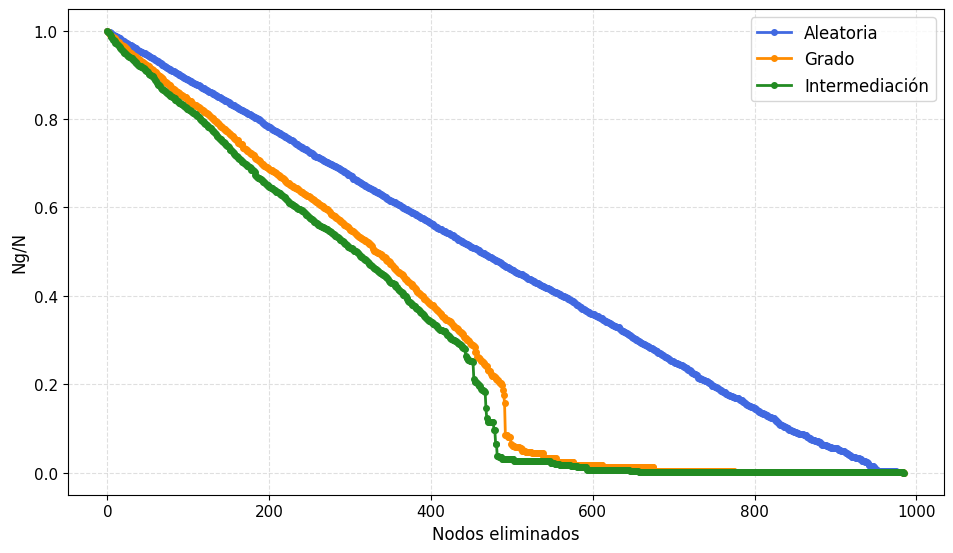

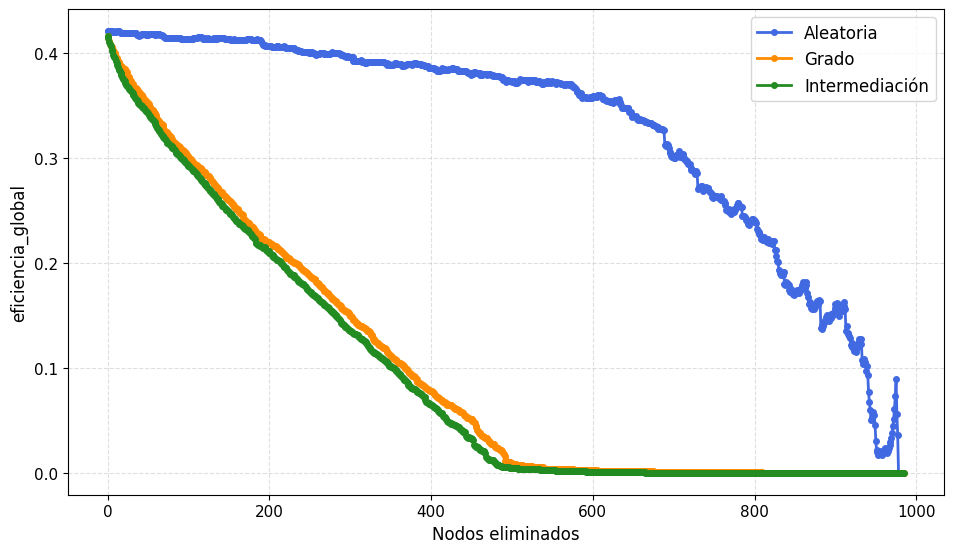

In [51]:
csvs = [
    'datasets/robustez/email_random_node_delete.csv',
    'datasets/robustez/email_grade_node_delete.csv',
    'datasets/robustez/email_betweenness_node_delete.csv'
]
labels = ['Aleatoria', 'Grado', 'Intermediación']

plot_robustness_comparison(csvs, labels, 'Ng/N')
plot_robustness_comparison(csvs, labels, 'eficiencia_global')